# Tree Genereration

## Input Selection

In [4]:
import ipywidgets as widgets
import os, shutil
from IPython.display import clear_output

SAMPLE = None

project_path        = os.path.dirname(os.getcwd())
data_path           = project_path + '/data'
custom_input        = data_path + "/custom_input.txt"
children_file_path  = data_path + "/small.children.txt"
cat_code_file_path  = data_path + "/small.catcode.txt"
word2vec            = data_path + "/glove.txt"
nballs_path         = data_path + "/nballs.txt"

def generate_files(glove_file_path, output_path, sample, input_file_path):
    generate_files_string_command = "main_vis.py --gen --w2v %s --output %s --sample %s --input %s"
    command = generate_files_string_command%(glove_file_path, output_path, sample, input_file_path)     
    %run $command
    check_input_for_nballs()
    
def generate_nballs(glove_file_path):
    generate_balls_string_command = "../nball.py --train_nball %s --w2v %s --ws_child %s --ws_catcode %s --log %s/log.txt"
    command = generate_balls_string_command%(nballs_path, glove_file_path, children_file_path, cat_code_file_path, data_path)     
    %run $command
    check_input_for_vis()
    
def visualize_balls():
    vis_string_command = "main_vis.py --vis --balls %s --children"
    command = vis_string_command%(nballs_path, children_file_path)     
    %run $command
    
def write_data_to_file(file_path, lines):
    with open(file_path, 'w') as file:
        for line in lines:
            file.write(line)
            if not '\n' in line:
                file.write("\n")

# UI Widgets
input_examples = widgets.Combobox( placeholder='Choose Example', description='Input:',
    options=['Cities','Fruits','Small','Medium','Large','Custom']
)

check_input_button     = widgets.Button(description='Check', button_style='success')
words_input            = widgets.Textarea(value='',description='Words', placeholder='keywords comma separated')
word2vec_path_input    = widgets.Text(placeholder='word2vec', value = word2vec, description='word2vec')
generate_tree_button   = widgets.Button(description='Generate Tree', button_style='success')
generate_nballs_button = widgets.Button(description='Generate Balls', button_style='success')
vis_button             = widgets.Button(description='Vis', button_style='success')
buttons_box            = widgets.Box([word2vec_path_input,generate_tree_button])
custom_box             = widgets.Box([words_input,check_input_button])


# UI Widget functions
def on_input_example_choose(change):
    global SAMPLE
    if change['type'] == 'change' and change['name'] == 'value':
        choosen_values = change['new']
        input_examples.disabled = True
        SAMPLE = choosen_values
        if (choosen_values == 'Custom'):
            display(custom_box)
            SAMPLE = None
        else:
            display(buttons_box)

def on_check_button_clicked(button):
    parsed_tokens = [x.strip() for x in str(words_input.value).split(',')]
    words = [x for x in parsed_tokens if x]
    if len(words) > 0:
        words_input.disabled = True
        check_cutom_input_button.disabled = True
        write_data_to_file(custom_input,words)
        display(buttons_box)
    else:
        print("Can't parse your input! Try Again!")
        
def check_input_for_nballs():
    if os.path.exists(children_file_path) and os.path.exists(cat_code_file_path):
        display(generate_nballs_button)
    
def check_input_for_vis():
    if os.path.exists(nballs_path):
        display(vis_button)
    
def on_generate_tree_button_clicked(button):
    if word2vec_path_input.value:
        word2vec_path_input.disabled = True
        generate_tree_button.disabled = True
        generate_files(word2vec_path_input.value, data_path, SAMPLE, custom_input)
        
def on_generate_balls_button_clicked(button):
    print("Start Generating balls")
    generate_nballs_button.disabled = True
    generate_nballs(word2vec_path_input.value)

def on_vis_button_clicked(button):
    visualize_balls()
    
# Set Widget listeners
input_examples.observe(on_input_example_choose)
check_input_button.on_click(on_check_button_clicked)
generate_tree_button.on_click(on_generate_tree_button_clicked)
generate_nballs_button.on_click(on_generate_balls_button_clicked)
vis_button.on_click(on_vis_button_clicked)

# Start UI nteraction
display(input_examples)

Combobox(value='', description='Input:', options=('Cities', 'Fruits', 'Small', 'Medium', 'Large', 'Custom'), p…

Box(children=(Text(value='C:\\Users\\Mhd-Ghanem\\Desktop\\Lab\\nball4tree-original/data/glove.txt', descriptio…

Accordion(children=(VBox(children=(Box(children=(Label(value='Filter:'), Button(button_style='success', descri…

<IPython.core.display.Javascript object>


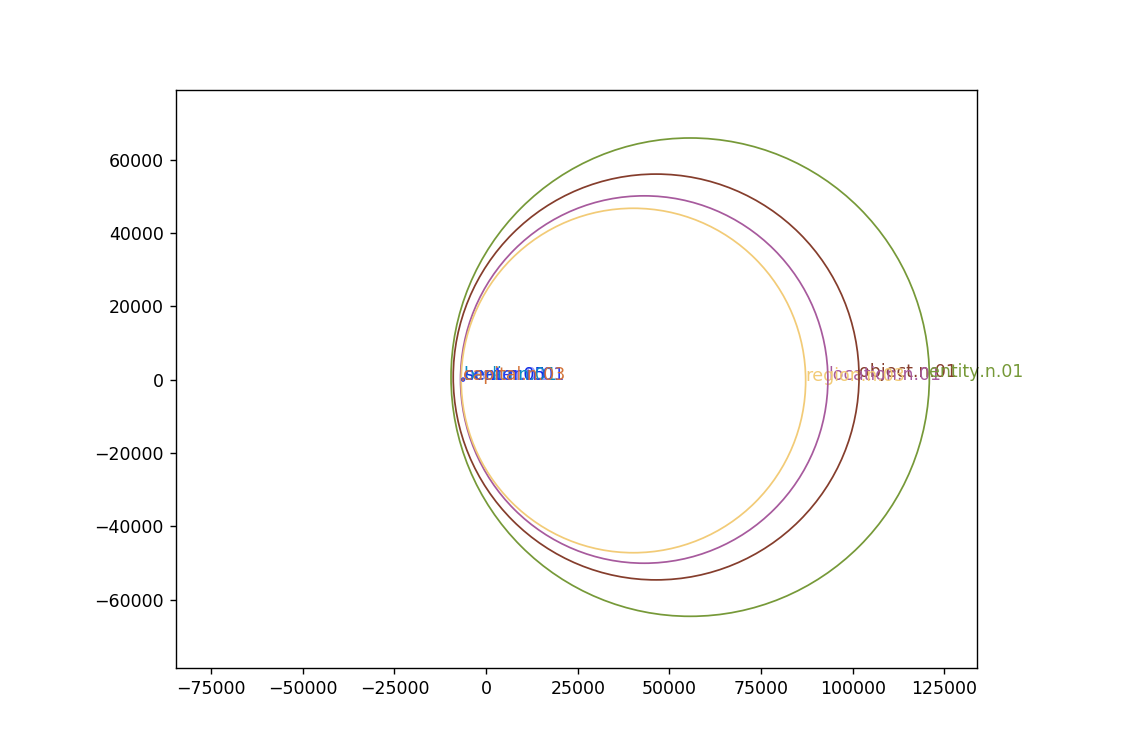

In [53]:
%matplotlib notebook
from matplotlib import pyplot
from matplotlib.patches import Circle
import matplotlib.animation as animation

import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np
import random
import os

from sklearn.decomposition import PCA
from decimal import *
from math import pi, cos, sin



project_path        = os.path.dirname(os.getcwd())
data_path           = project_path + '/data'
children_file_path  = data_path + "/small.children.txt"
nballs_path         = data_path + "/nballs.txt"
output_path         = data_path + "/output.txt"
before_fix_path     = output_path + "_before"
after_fix_path      = output_path + "_after"

if not os.path.isdir(data_path):
    os.mkdir(data_path)

ax,fig = None, None
circles_dic_before, circles_dic_after, children_dic, checkbox_dic, colors_dic = {}, {}, {}, {}, {}
is_after = True

# UI Widgets
select_all_button               = widgets.Button(description='Select All'     , button_style='success')
unselect_all_button             = widgets.Button(description='Unselect All'   , button_style='danger')
select_unselect_all_buttons_box = widgets.Box([widgets.Label(value="Filter:"),select_all_button,unselect_all_button])
mode_toggle_button              = widgets.ToggleButtons(description='', options=['Before', 'After'], value='After')
mode_box                        = widgets.Box([widgets.Label(value="Mode:"),mode_toggle_button])
margin                          = widgets.Label(value="")


def show_options(grid):
    global select_unselect_all_buttons_box, mode_toggle_button
    options_list = widgets.VBox([select_unselect_all_buttons_box, grid, margin,mode_box])
    mode_toggle_button = widgets.ToggleButtons(options=['Before', 'After'])
    accordion = widgets.Accordion(children=[options_list])
    accordion.set_title(0, 'Visulization Options')
    display(accordion)


def reduce_and_fix(nball_file_path, children_file_path, output_path):
    reduce_and_fix_string_command = "main_vis.py --reduceAndFix --balls %s --children %s --output %s"
    command = reduce_and_fix_string_command%(nball_file_path, children_file_path, output_path)     
    %run $command
    read_files()
    
def generate_colors(words):
    global colors_dic
    colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(words))]
    for i, word  in enumerate(words):
        colors_dic[word] = colors[i]
    
def read_files():
    global circles_dic_before, circles_dic_after
    read_balls_file(before_fix_path, circles_dic_before)
    read_balls_file(after_fix_path, circles_dic_after)
    read_children_file(children_file_path, children_dic)
    words = list(circles_dic_after.keys())
    create_checkbox_grid(words)
    generate_colors(words)
    plot_dic("", [])
    
def read_balls_file(file_path, circles_dic=None):
    if circles_dic is None:
        circles_dic = dict()
    with open(file_path, mode="r", encoding="utf-8") as balls_file:
        for line in balls_file.readlines():
            tokens = line.strip().split()
            circles_dic[tokens[0]] = [float(ele) for ele in tokens[1:]]
        return circles_dic
    
def read_children_file(ws_children_file, children_dic=None):
    if children_dic is None:
        children_dic = dict()
    with open(ws_children_file, 'r') as children_file:
        for ln in children_file:
            tokens = ln[:-1].split()
            children_dic[tokens[0]] = tokens[1:]
        return children_dic

def create_checkbox_grid(words):
    words.sort()
    global ax, fig, checkbox_dic, gride
    for word in words:
        checkbox_changed = widgets.Checkbox(value=True, description=word)
        checkbox_changed.observe(checkbox_changed_callback)
        checkbox_dic[word] = checkbox_changed
    grid = widgets.GridBox(list(checkbox_dic.values()), layout=widgets.Layout(grid_template_columns="repeat(5, 150px)"))
    show_options(grid)
    fig, ax = pyplot.subplots()
    ax.set_aspect(1)
    fig.set_figheight(6)
    fig.set_figwidth(9)
    
    
def plot(vectors, radius, words, fig, ax):
    global checkbox_dic
    for i, vector in enumerate(np.array(vectors)):
        e = Circle(xy=vector, radius=float(radius[i]))
        ax.add_artist(e)
        e.set_edgecolor(colors_dic[words[i]])
        e.set_facecolor('none')

    x = [i[0] for i in vectors]
    y = [i[1] for i in vectors]
    max_radius = max(radius)
    if max_radius < 1:
        max_radius = 1
    margin = 1.2 * max_radius
    ax.set_xlim([min(x) - margin, max(x) + margin])
    ax.set_ylim([min(y) - margin, max(y) + margin])
    ax.set_aspect(1)

    for i, word in enumerate(words):
        ax.text(vectors[i][0] + radius[i], vectors[i][1], '%s' % (str(word)), size=10, zorder=1, color=colors_dic[words[i]])
    fig.show()


def plot_dic(figure_title, filtered_words=[]):
    global is_after
    if is_after:
        circles_dic = circles_dic_after
    else:
        circles_dic = circles_dic_before
    if len(filtered_words) > 0:
        circles_dic = {k: circles_dic[k] for k in filtered_words if k in circles_dic}
    words = list(circles_dic.keys())
    radius = [values[-1] for values in circles_dic.values()]
    vectors = [np.multiply(np.array(values[:2]), values[-2]) for values in circles_dic.values()]
    plot(vectors, radius, words, fig, ax)


def update_plot():
    pyplot.cla()
    showen_words = set()
    for word,checkbox in checkbox_dic.items():
        if checkbox.value:
            showen_words.add(word)
    if len(showen_words) == 0:
        pyplot.cla()
    else:
        plot_dic("", showen_words)
        

def disable_sub_tree(word):
    checkbox_dic[word].unobserve_all()
    checkbox_dic[word].value = False
    checkbox_dic[word].observe(checkbox_changed_callback)
    children = children_dic[word]
    if len(children) > 0:
        for child in children:
            disable_sub_tree(child)
            
def enable_parents(word):
    parent = None
    for key, chilren in children_dic.items():
        if word in set(chilren):
            parent = key
            break
    if parent and parent != '*root*':
        checkbox_dic[parent].unobserve_all()
        checkbox_dic[parent].value = True
        checkbox_dic[parent].observe(checkbox_changed_callback)
        enable_parents(parent)

def checkbox_changed_callback(b):
    if b['type'] == 'change' and b['name'] == 'value':
        check_word = b['owner'].description
        if not b['owner'].value: # uncheck case    
            disable_sub_tree(check_word)
        else:
            enable_parents(check_word)
        update_plot()


# UI Widget functions
def on_visualize_balls_button_clicked(button):
    nball_file_path = nball_path_input.value
    reduce_and_plot(nball_file_path)
    nball_input_buttons_box.layout.visibility = 'hidden'
        
def set_state_to_all_checkboxs(state):
    for word,checkbox in checkbox_dic.items():
        checkbox.unobserve_all()
        checkbox.value = state
        checkbox.observe(checkbox_changed_callback)
    
def on_select_all_button_clicked(button):
    set_state_to_all_checkboxs(True)
    update_plot()
    
def on_unselect_all_button_clicked(button):
    set_state_to_all_checkboxs(False)
    update_plot()
        
def mode_changed_callback(b):
    global is_after
    if b['type'] == 'change' and b['name'] == 'value':
        if b['new'] == 'After':
            is_after = True
        else:
            is_after = False
        update_plot()
    
# Set Widget listeners
select_all_button.on_click(on_select_all_button_clicked)
unselect_all_button.on_click(on_unselect_all_button_clicked)
mode_toggle_button.observe(mode_changed_callback)
    
# Start UI Interaction
def start():
    read_files()
    #reduce_and_fix(nballs_path, children_file_path, output_path)
    
start()